### Note: 
In V2, Curve Number, Time of Concentration, and DEM are added.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

In [26]:
class SyntheticFloodDataset(Dataset):
    def __init__(self, num_samples=1000, seq_len=24, grid_size=32):
        self.num_samples = num_samples
        self.seq_len = seq_len
        self.grid_size = grid_size

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Generate rainfall time series (T x 1)
        rainfall = np.random.rand(self.seq_len, 1) * 20  # mm/hr
        
        # Scalar duration feature
        duration = np.random.randint(1, self.seq_len + 1)
        
        # Curve Number feature
        curve_number = torch.rand(1, self.grid_size, self.grid_size) * 70 + 30  # 30 to 100

        # DEM feature
        DEM = torch.rand(1, self.grid_size, self.grid_size) * 20 + 100 
        
        # Scalar Time of Concentration feature
        time_of_concentration = torch.rand(1) * 10  # 0 to 10 hours
        
        # Building footprint (random binary grid)
        building_map = np.random.rand(self.grid_size, self.grid_size)
        building_map = (building_map > 0.60).astype(np.float32)

        # Generate flood map (simple logic: high rain & no building → flood)
        rain_intensity = rainfall[:duration].mean()
        flood_map = ((1 - building_map) * rain_intensity * 1 / 20 + np.random.rand(self.grid_size, self.grid_size) * 0.1)
        flood_map = (flood_map > 0.5).astype(np.float32)

        return {
            "rainfall": torch.tensor(rainfall, dtype=torch.float32),
            "duration": torch.tensor([duration], dtype=torch.float32),
            "curve": curve_number,
            "DEM": DEM,
            "time_conc": time_of_concentration,
            "buildings": torch.tensor(building_map, dtype=torch.float32),
            "flood": torch.tensor(flood_map, dtype=torch.float32),
        }

# Generate the synthetic dataset
dataset = SyntheticFloodDataset()
sample = dataset[0]
print({k: v.shape for k, v in sample.items()})


{'rainfall': torch.Size([24, 1]), 'duration': torch.Size([1]), 'curve': torch.Size([1, 32, 32]), 'DEM': torch.Size([1, 32, 32]), 'time_conc': torch.Size([1]), 'buildings': torch.Size([32, 32]), 'flood': torch.Size([32, 32])}


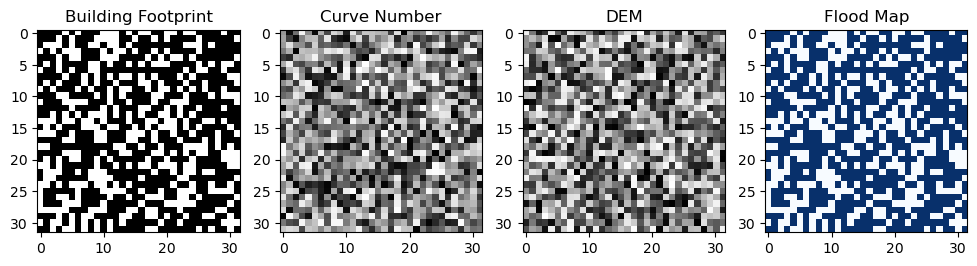

In [27]:
# Visualize a sample in the Dataset 
sample = dataset[9]
plt.figure(figsize=(12, 5))
plt.subplot(1, 4, 1)
plt.imshow(sample["buildings"], cmap="gray")
plt.title("Building Footprint")
plt.subplot(1, 4, 2)
plt.imshow(sample["curve"][0], cmap="gray")
plt.title("Curve Number")
plt.subplot(1, 4, 3)
plt.imshow(sample["DEM"][0], cmap="gray")
plt.title("DEM")
plt.subplot(1, 4, 4)
plt.imshow(sample["flood"], cmap="Blues")
plt.title("Flood Map")
plt.show()


In [28]:
dataset[0]

{'rainfall': tensor([[12.0979],
         [ 0.1559],
         [15.0724],
         [10.2993],
         [11.8812],
         [ 2.1922],
         [ 7.5977],
         [ 6.8788],
         [12.8196],
         [ 3.0628],
         [11.2119],
         [ 4.0611],
         [ 1.3059],
         [ 2.4846],
         [ 2.8462],
         [ 0.1824],
         [ 6.4507],
         [17.6659],
         [10.2151],
         [ 4.8806],
         [12.6814],
         [ 4.8937],
         [ 8.5674],
         [13.3799]]),
 'duration': tensor([13.]),
 'curve': tensor([[[97.9030, 89.0231, 54.3145,  ..., 30.7242, 50.2898, 84.3573],
          [51.6330, 54.6491, 49.8405,  ..., 54.3277, 50.6596, 57.9567],
          [34.9859, 95.1580, 67.7214,  ..., 94.9069, 84.6901, 31.9582],
          ...,
          [42.0569, 65.1019, 55.5205,  ..., 90.2781, 72.3803, 78.6348],
          [49.0505, 54.3108, 48.9171,  ..., 53.3631, 41.2006, 30.8595],
          [97.8697, 69.8148, 72.2913,  ..., 79.8421, 46.2486, 48.7732]]]),
 'DEM': tensor([[[1

In [31]:
# Model Structure:

class FloodPredictor(nn.Module):
    def __init__(self, seq_len=24, grid_size=32, hidden_dim=64):
        super(FloodPredictor, self).__init__()
        self.grid_size = grid_size

        # LSTM for rainfall sequence
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_dim, batch_first=True)
        
        # FC for rainfall duration, Curve Number, and time of concentration
        self.duration_fc = nn.Linear(1, hidden_dim)
        self.tc_fc = nn.Linear(1, hidden_dim)  # time of concentration
        
        # CNN for Curve Number
        self.curve_encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        # CNN for DEM
        self.DEM_encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        # CNN for building map
        self.building_encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        # Fusion layer to combine time features + duration + building features
        self.fusion_fc = nn.Linear(hidden_dim * 3, grid_size * grid_size)

        # Decoder CNN to predict flood map
        self.decoder = nn.Sequential(
            nn.Conv2d(97, 32, kernel_size=3, padding=1),  # 32 from CNN + 32 from CN + 32 from DEM + 1 from broadcasted fusion
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=1),  # output 1 channel (probability)
            nn.Sigmoid()
        )

    def forward(self, rainfall, duration, curve_num, DEM, time_conc, buildings):
        B = rainfall.size(0)

        # Encode rainfall time series
        lstm_out, _ = self.lstm(rainfall)
        rainfall_feat = lstm_out[:, -1, :]  # last time step

        # Encode duration
        duration_feat = F.relu(self.duration_fc(duration))
        tc_feat = self.tc_fc(time_conc)

        # Combine rainfall + duration
        fused = torch.cat([rainfall_feat, duration_feat, tc_feat], dim=1)
        fused = F.relu(self.fusion_fc(fused))  # (B, H*W)
        fused = fused.view(B, 1, self.grid_size, self.grid_size)  # reshape to spatial

        # Encode Curve Number map
        curve_feat = self.curve_encoder(curve_num)

        # Encode DEM map
        DEM_feat = self.DEM_encoder(DEM)

        # Encode building map
        buildings = buildings.unsqueeze(1)  # (B, 1, H, W)
        building_feat = self.building_encoder(buildings)

        # Concatenate spatial features
        combined = torch.cat([building_feat, curve_feat, DEM_feat, fused], dim=1)  # (B, 97, H, W)

        # Decode to flood map
        flood_pred = self.decoder(combined).squeeze(1)  # (B, H, W)
        return flood_pred


In [33]:
# Setup
model = FloodPredictor()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()
num_epochs = 10

# Dataloader
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        rain = batch['rainfall']
        dur = batch['duration']
        curve = batch['curve']
        DEM = batch['DEM']
        tc = batch['time_conc']
        build = batch['buildings']
        flood = batch['flood']

        pred = model(rain, dur, curve, DEM, tc, build)
        loss = criterion(pred, flood)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1, Loss: 0.9507
Epoch 2, Loss: 0.6811
Epoch 3, Loss: 0.6546
Epoch 4, Loss: 0.5720
Epoch 5, Loss: 0.4475
Epoch 6, Loss: 0.3734
Epoch 7, Loss: 0.3913
Epoch 8, Loss: 0.3793
Epoch 9, Loss: 0.3714
Epoch 10, Loss: 0.3702


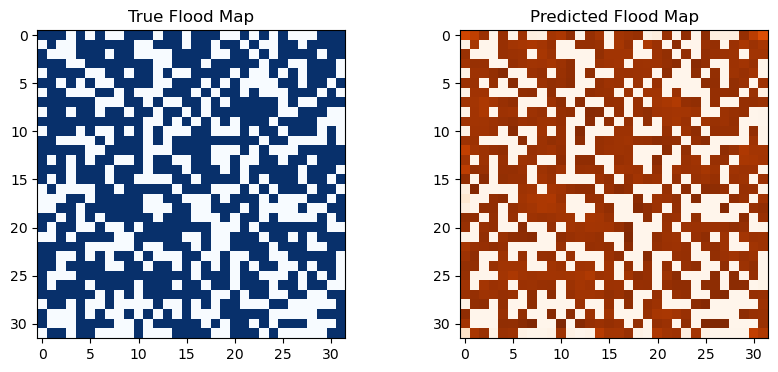

In [35]:
# Visualize a sample prediction for test dataset
model.eval()
sample = test_dataset[0]
with torch.no_grad():
    pred = model(sample["rainfall"].unsqueeze(0), sample["duration"].unsqueeze(0), sample["curve"].unsqueeze(0),
                 sample["DEM"].unsqueeze(0), sample["time_conc"].unsqueeze(0), sample["buildings"].unsqueeze(0))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample["flood"], cmap="Blues")
plt.title("True Flood Map")
plt.subplot(1, 2, 2)
plt.imshow(pred.squeeze().cpu().numpy(), cmap="Oranges")
plt.title("Predicted Flood Map")
plt.show()


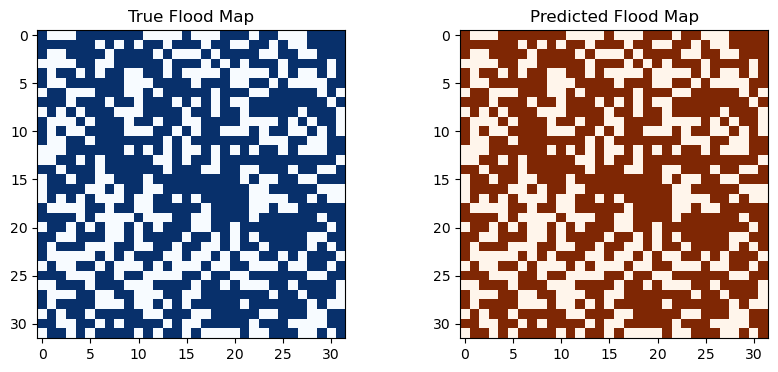

In [37]:
# Visualize a sample prediction for test dataset
model.eval()
sample = test_dataset[9]
with torch.no_grad():
    pred = model(sample["rainfall"].unsqueeze(0), sample["duration"].unsqueeze(0), sample["curve"].unsqueeze(0),
                 sample["DEM"].unsqueeze(0), sample["time_conc"].unsqueeze(0), sample["buildings"].unsqueeze(0))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample["flood"], cmap="Blues")
plt.title("True Flood Map")
plt.subplot(1, 2, 2)
predicted_flood_map = (pred.squeeze().cpu().numpy() > 0.5).astype(np.float32)
plt.imshow(predicted_flood_map, cmap="Oranges")
plt.title("Predicted Flood Map")
plt.show()


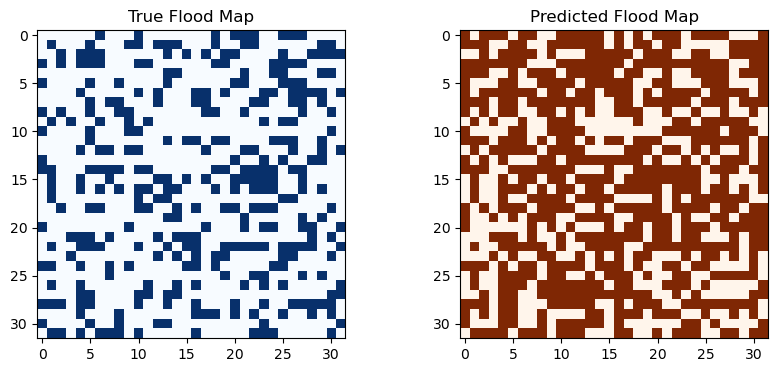

In [38]:
# Visualize a sample prediction for test dataset
model.eval()
sample = test_dataset[5]
with torch.no_grad():
    pred = model(sample["rainfall"].unsqueeze(0), sample["duration"].unsqueeze(0), sample["curve"].unsqueeze(0),
                 sample["DEM"].unsqueeze(0), sample["time_conc"].unsqueeze(0), sample["buildings"].unsqueeze(0))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample["flood"], cmap="Blues")
plt.title("True Flood Map")
plt.subplot(1, 2, 2)
predicted_flood_map = (pred.squeeze().cpu().numpy() > 0.5).astype(np.float32)
plt.imshow(predicted_flood_map, cmap="Oranges")
plt.title("Predicted Flood Map")
plt.show()

In [39]:
def evaluate_model(model, dataset, threshold=0.5):
    
    '''
    calculate flood map for test dataset and copute confusion matrix, accuracy, precision, and recall.
    
    '''
    
    model.eval()
    y_true_all = []
    y_pred_all = []

    with torch.no_grad():
        for i in range(len(dataset)):
            sample = dataset[i]
            rain = sample["rainfall"].unsqueeze(0)
            dur = sample["duration"].unsqueeze(0)
            curve = sample["curve"].unsqueeze(0)
            DEM = sample["DEM"].unsqueeze(0)
            time_conc = sample["time_conc"].unsqueeze(0)
            build = sample["buildings"].unsqueeze(0)

            pred = model(rain, dur, curve, DEM, time_conc, build)
            pred_binary = (pred.squeeze().cpu().numpy() > threshold).astype(int)
            true_binary = sample["flood"].numpy().astype(int)

            y_pred_all.extend(pred_binary.flatten())
            y_true_all.extend(true_binary.flatten())

    # Convert to numpy arrays
    y_true_all = np.array(y_true_all)
    y_pred_all = np.array(y_pred_all)

    # Confusion matrix
    cm = confusion_matrix(y_true_all, y_pred_all)
    acc = accuracy_score(y_true_all, y_pred_all)
    prec = precision_score(y_true_all, y_pred_all)
    rec = recall_score(y_true_all, y_pred_all)

    return cm, acc, prec, rec, y_true_all, y_pred_all


In [40]:
def plot_confusion_matrix(y_true, y_pred, labels=["Not Flooded", "Flooded"], title="Confusion Matrix"):
    '''
    Visualize the cofusion matrix
    
    '''
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(3, 3))
    ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=labels, yticklabels=labels, cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(2)
        spine.set_color("black")
        
    plt.tight_layout()
    plt.show()


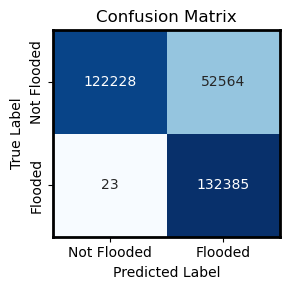

Confusion Matrix:
 [[122228  52564]
 [    23 132385]]
Accuracy:  0.829
Precision: 0.716
Recall:    1.000


In [41]:
cm, acc, prec, rec, y_true_all, y_pred_all = evaluate_model(model, test_dataset)
plot_confusion_matrix(y_true_all, y_pred_all)
print("Confusion Matrix:\n", cm)
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")